# Elbow and Sillhouette Method - Notes
This project is based on Oscar Defelice's GitHub example (see the README). The dataset used in this example is part of scikit-learn and it is called Iris. 

<h3 style="color:pink;">K-Means Algorithm Recap</h3> 

The k-means algorithm searches for a pre-determined number of clusters (usually denoted as k) within an unlabeled multidimensional dataset. It accomplishes this using a simple conception of what the optimal clustering looks like:

* The "cluster center" also called centroid is the arithmetic mean of all the points belonging to the cluster.
* Each point is closer to its own centroid than to other cluster centers.

Those two assumptions are the basis of the k-means model. For a more detailed explanation on the algorithm and practical examples, check the other notebooks in this repository.

<h3 style="color:darkblue;">Initial Code</h3> 

In [163]:
# Libraries Imports 
import pandas as pd
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt # Create the plots 
import matplotlib.cm as cm # Apply color schemes in plots 

from sklearn import datasets
from sklearn.cluster import KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score # score = returns a value between -1 and 1
                                                                 # samples = returns silhouette score for each individual sample

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # Supresses future warnings 

In [165]:
iris = datasets.load_iris() # Load the dataset
df_iris = pd.DataFrame(iris.data, columns = iris.feature_names) # Transform the data in a pandas DataFrame (1)
X = np.array(df_iris.loc[:, iris.feature_names]) # Extract the numerical data as a NumPy matrix (used in KMeans) (2)

**1.** <br>
Takes the raw data from the Iris dataset (iris.data) and converts it into a pandas DataFrame, giving it column names from iris.feature_names. In short, this transforms the raw array into a table with labels. 

**Why it’s useful:**
A DataFrame is easier to read, explore, and manipulate than a plain NumPy array. With this step, we can do things like:

* **df_iris.head()** <br>
  <span style="color:pink"># Show first 5 rows</span>
* **df_iris.describe()** <br>
  <span style="color:pink"># Summary statistics</span>
* **df_iris['sepal length (cm)'].mean()** <br>
  <span style="color:pink"># Get the average of a specific feature</span>

Which is especially handy during exploratory data analysis or if you later want to visualize specific features.

**2.**<br>
Extracts the numerical data back as a NumPy array, which is the format required by most **scikit-learn** algorithms (like KMeans). 
* While DataFrames are great for display and analysis, most ML algorithms in **scikit-learn** require data in the form of a NumPy array. This line ensures that you're giving only the input features (not any extra columns like species labels, if they existed) in the correct format.

<h3 style="color:darkblue;">Elbow Method</h3> 

The **Elbow Method** helps us determine the optimal number of clusters (k) to use in our K-Means algorithm. It does this by analyzing the **inertia** (also called within-cluster sum of squares, or **WSS**), which measures how tightly the data points are grouped around the centroids. Inertia is calculated as the sum of the squared distances from each data point to the center of its respective cluster. The lower the inertia, the better — because it means the points are more compact and well-clustered.

In [178]:
inertias = [] # List that stores the internal error (WSS) of each KMeans
range_clusters = range(1, 11) # The k values we want to test

for n in range_clusters:
    kmeans = KMeans(n_clusters=n, random_state=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_) # WSS

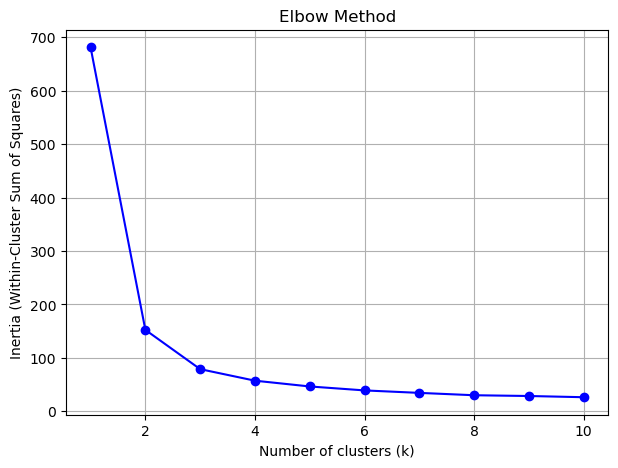

In [188]:
# Elbow Plot
plt.figure(figsize=(7, 5))
plt.plot(range_clusters, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

Once we have the Elbow plot, we need to search for the part in the graph where we have a "elbow" looklike point, a "break"". This is the point where we don't have either too few clusters (which would end up grouping points that don't have similar characteristics) or too many unnecessary clusters. In this case, k = 3 is the best value. 

Once we do our plotting, we notice a few points:

* As k increases (more clusters), inertia decreases because more clusters fit the data more precisely (reducing the distance between points and their cluster centers).
* After a certain point, the decrease in inertia starts to slow down. This happens because **adding more clusters doesn't significantly improve the fit**. This slowing-down point looks like an **elbow** or a "bend" in the graph.

The **"elbow"** is the point on the graph where inertia stops decreasing sharply and starts to flatten out. If k is too large, you end up with many small clusters that are unnecessary, making the model more complex without any real benefit.

By looking at our graph, we know that the best value for **k** is 3. Now, we are ready to finish our K-Means algorithm. 

In [194]:
km = KMeans(n_clusters = 3)
km.fit(X);

In [196]:
y_kmeans = km.predict(X)

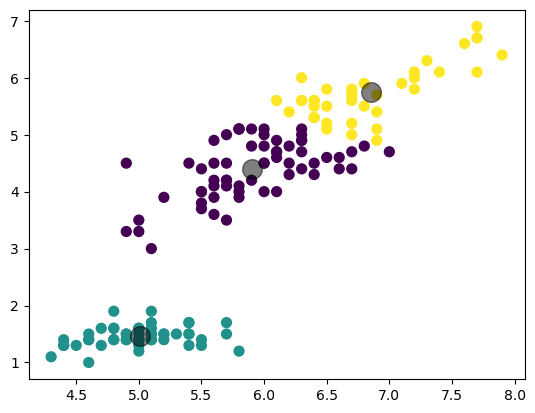

In [198]:
# Clusters Plot
plt.scatter(X[:, 0], X[:, 2], c=y_kmeans, s=50, cmap='viridis')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 2], c='black', s=200, alpha=0.5);

<h3 style="color:darkblue;">Silhouette - Analysis</h3>

An important feature of k-means is that one has to choose in advance the number of clusters we use to classify the dataset. One can easily image that on a dataset of 1000 observations k = 1 and k = 1000 are poor choices, hardly adding new informations to our knowledge. Leaving aside these extremal cases, how one can answer to the question **which is the "right" number of clusters?** <br><br>

**Silhouette** refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified. In other words, it's a **way to measure how close each point in a cluster is to the points in its neighboring clusters**, helping us find the optimum value for k during k-means clustering. Silhouette values lies in the range of **[-1, 1]**. 

* A value of **+1** indicates that the sample is far away from its neighboring cluster and very close to the cluster it's assigned.
* A value of **-1** indicates that the point is close to its neighboring cluster than to the cluster it's assigned.
* A value of **0** means it's at the boundary of the distance between the two cluster.

Value of **+1** is **ideal** and **-1** is **least preferred**. Hence, **higher the value better is the cluster configuration** (the data set is well matched in the cluster assignment).<br><br>

The silhouette score can be calculated with any distance metric, such as the Euclidean distance or the Manhattan distance.

<h3 style="color:darkblue;">Silhouette - Mathematical Definiton</h3> 

We define the silhouette (**$s_i$**) as: 

$$
s_i = \frac{b_i - a_i}{\max(b_i, a_i)}
$$

Where: 
* **$a_i$** <br>
  The **mean distance of point i w.r.t to all the other points in the cluster it's assigned**.<br>
  We can interpret **$a_i$** as a measure of how well the point is assigned to the cluster. Smaller the value, better the assignment.

* **$b_i$** <br>
  The **mean distance of point i w.r.t. to other points to its closet neighbouring cluster B**. <br>
  Cluster B is the cluster to which point i is not assigned to but its distance is closest amongst all other cluster. <br><br>

For $s_i$ to be close to 1: 

* **$a_i$** has to be very small compared to **$b_i$** (**$a_i$** **<< $b_i$**). This happens when **$a_i$** is very close to its assigned cluster. <br>
* A large value of **$b_i$** implies the data point is extremely far from its next closest cluster.

<h3 style="color:darkblue;">Silhouette - Code</h3> 
Here is the sklearn implementation of silhouette analysis: 

In [255]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8] # The values of k we want to test

For n_clusters = 2 The average silhouette_score is : 0.6810461692117462
For n_clusters = 3 The average silhouette_score is : 0.5528190123564095
For n_clusters = 4 The average silhouette_score is : 0.4974551890173751
For n_clusters = 5 The average silhouette_score is : 0.48874888709310566
For n_clusters = 6 The average silhouette_score is : 0.36648040289008327
For n_clusters = 7 The average silhouette_score is : 0.35200746716162923
For n_clusters = 8 The average silhouette_score is : 0.3538958470891033


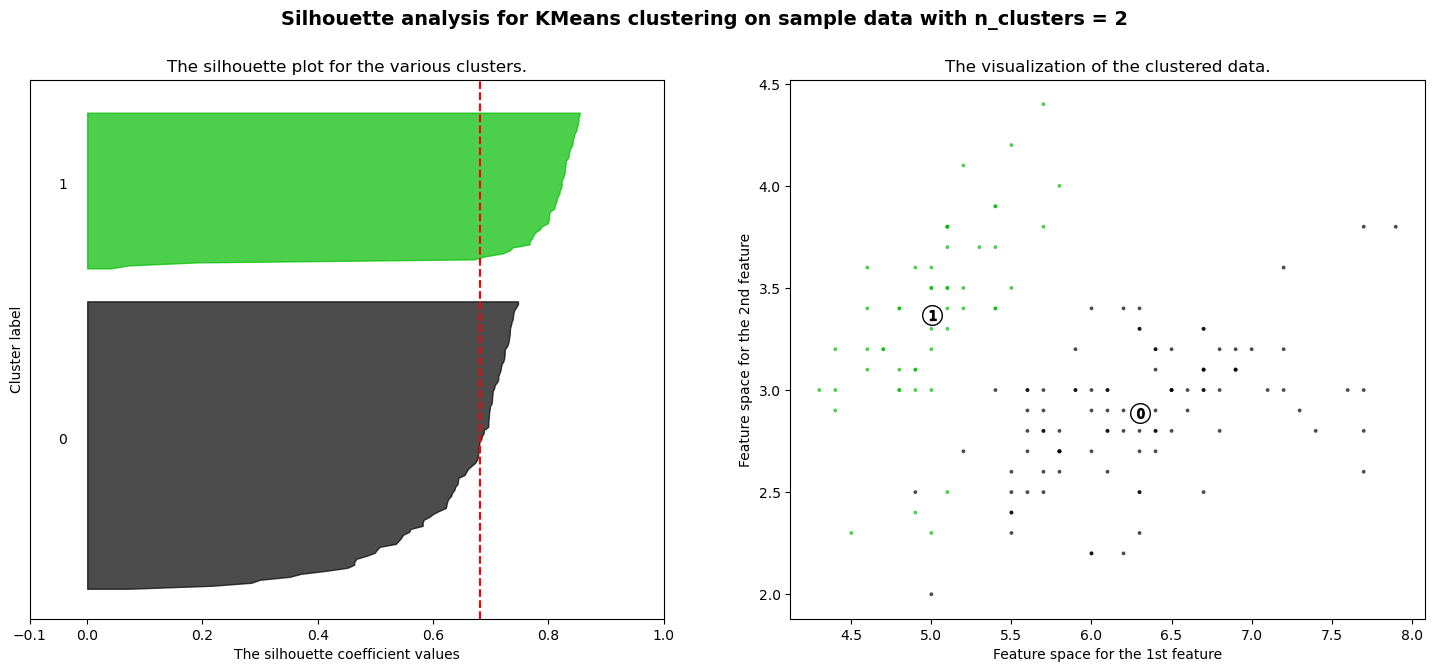

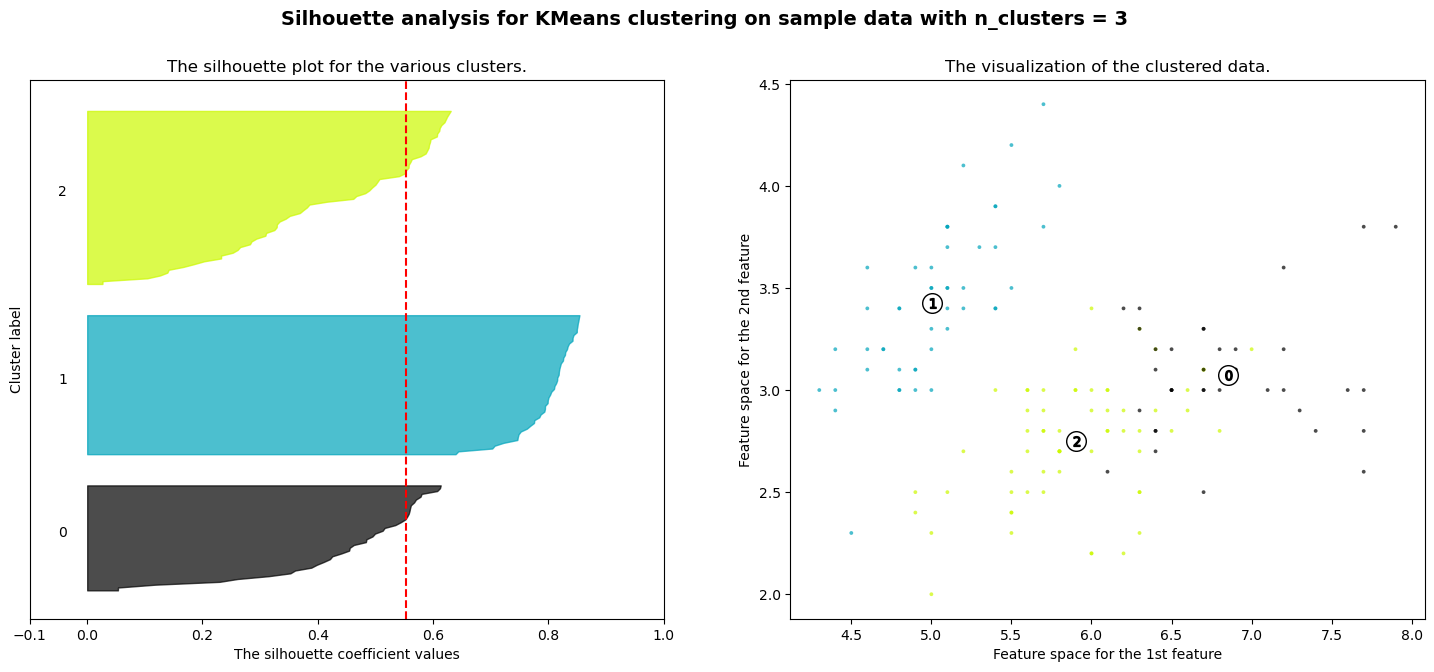

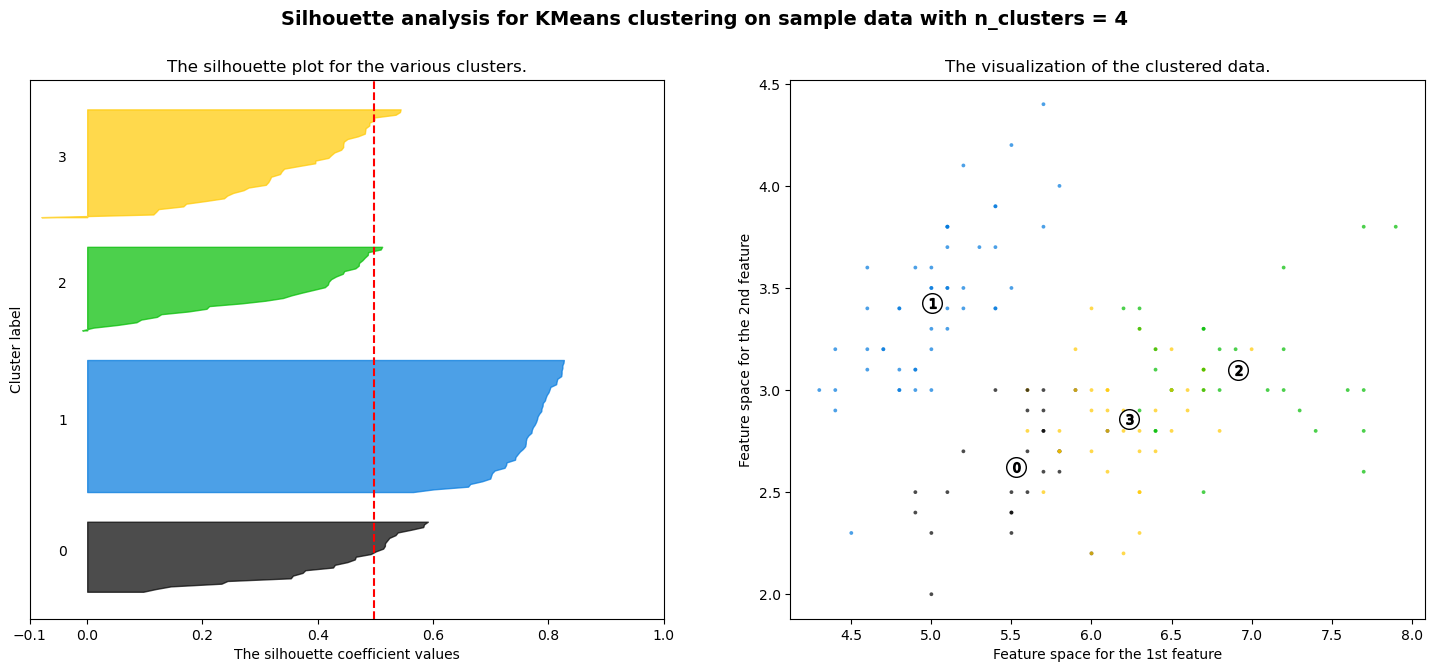

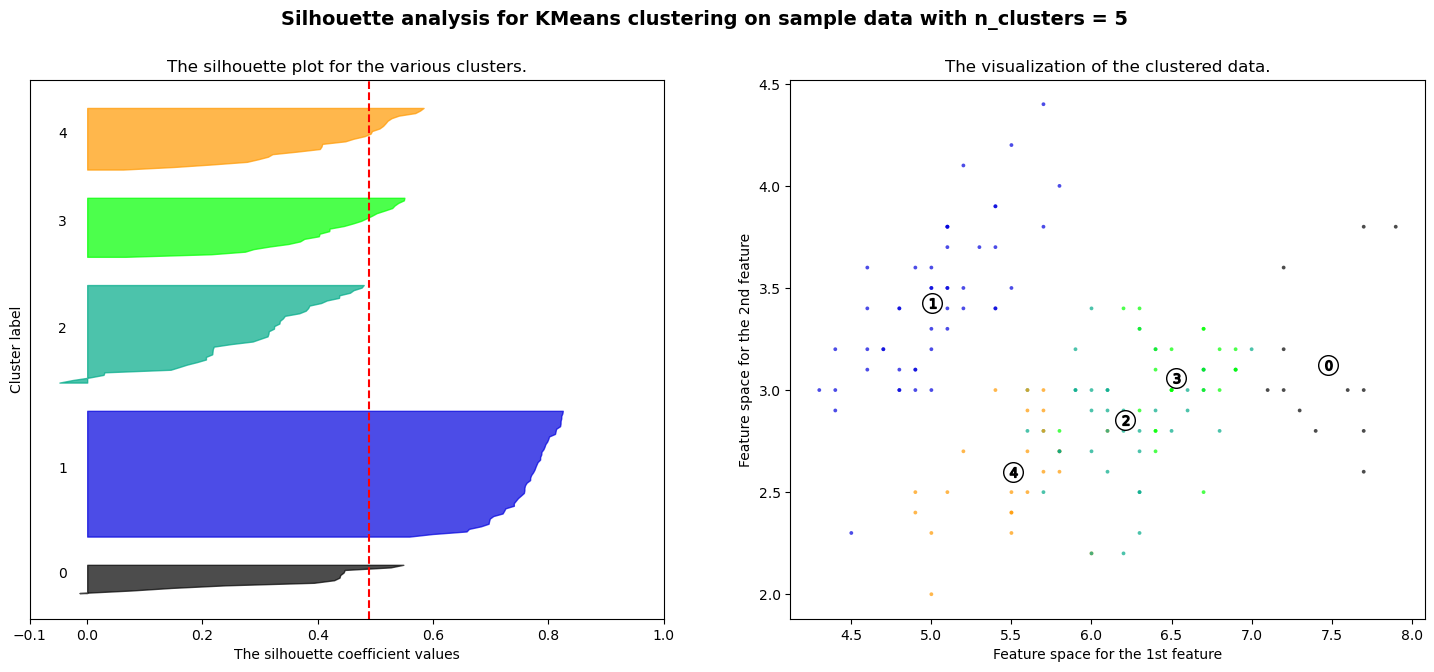

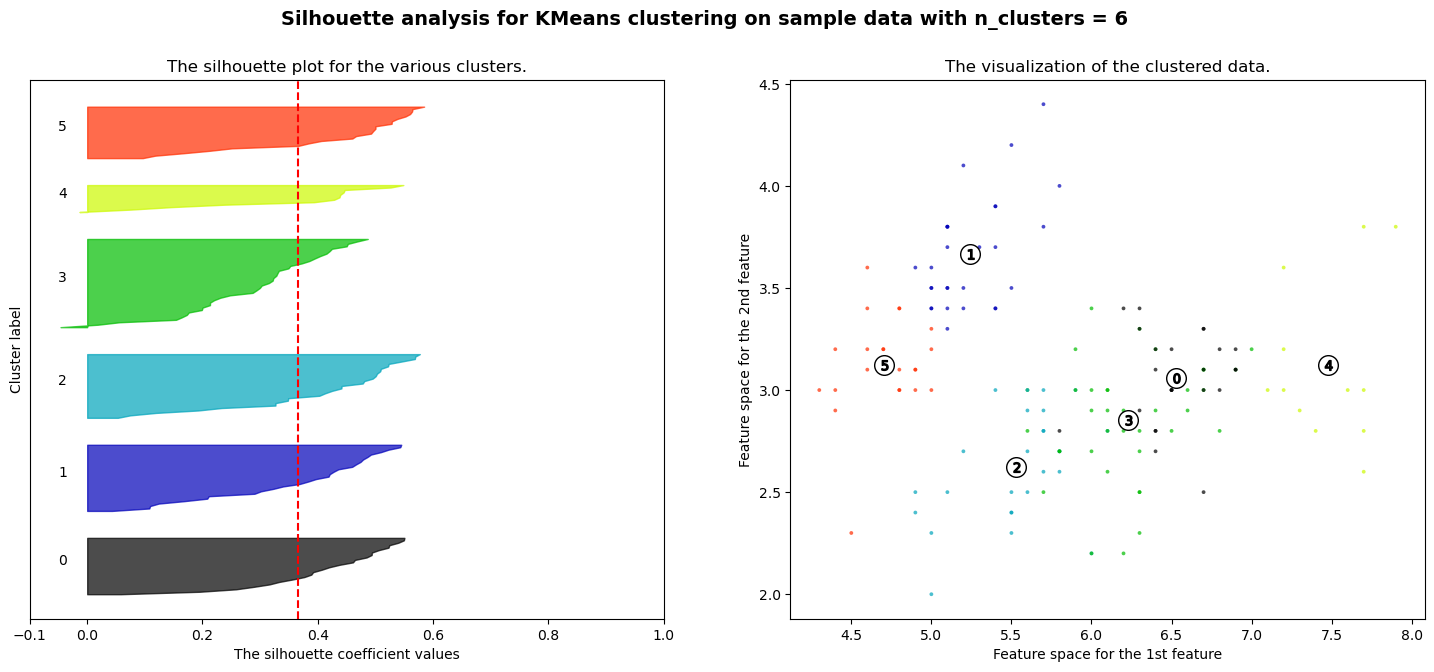

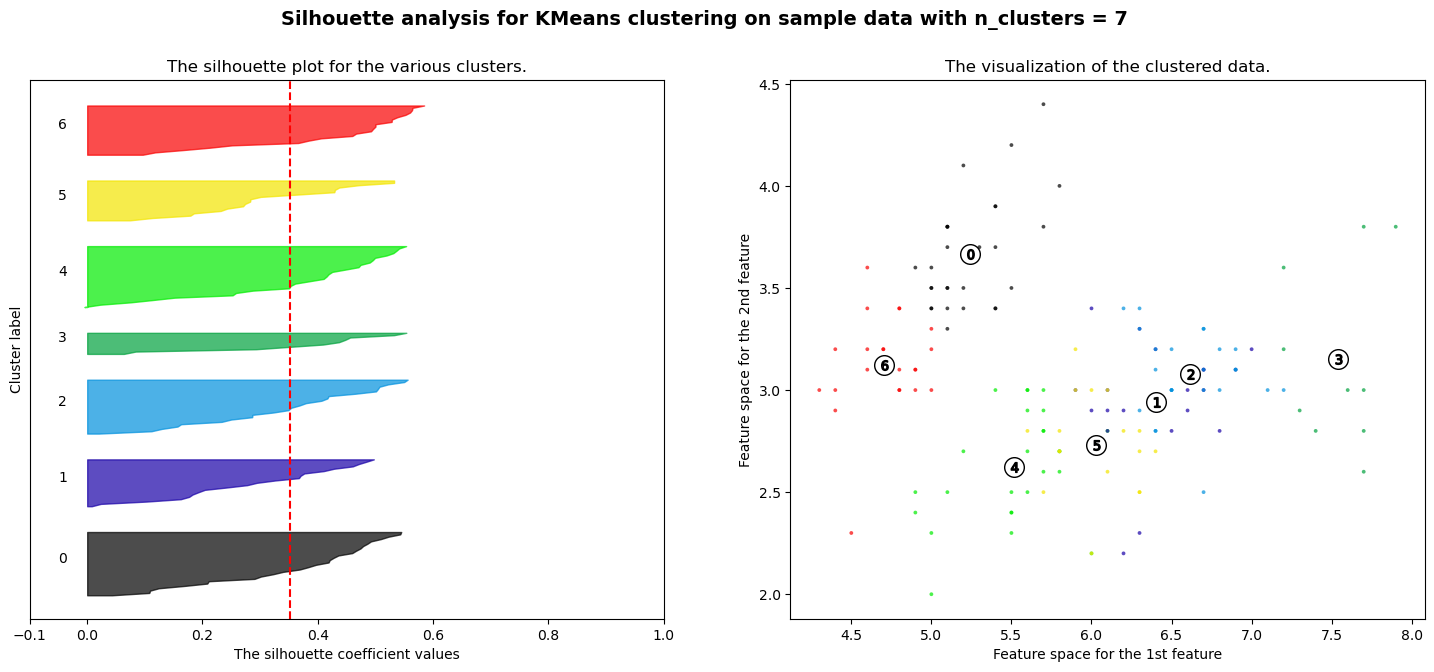

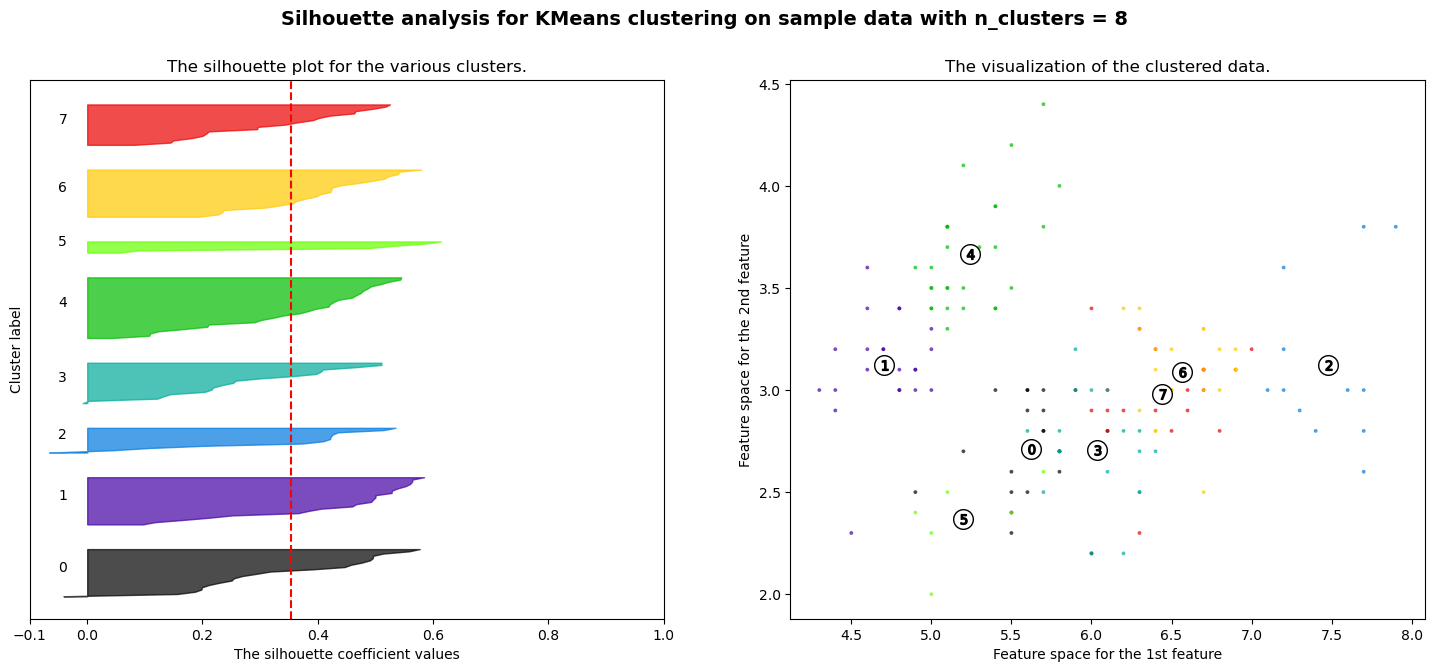

In [257]:
# Loop for each value of n_cluster 
for n_clusters in range_n_clusters:

    # Creates 2 graphs side by side: 1 for the silhouette and 1 for the clusters
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # Set the axis limits for the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example, all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Creates a new KMeans with the actual n_cluster
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Calculates the average silhouette coefficient (measure of cluster separation)
    # Calculates the average of ALL points (how well the clusters are, on average, separated from each other)
    # -1 a 1 (used to determine which k is better)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    # Returns an array with 1 value for each point
    # Each value shows how well this point is placed in its current cluster 
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # Silhouette Plot
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

<h3 style="color:darkblue;">Silhouette - Graph Interpretation</h3> 

**Silhouette Graph**
* Each colorful block represents a different cluster.
* The horizontal width of each block shows the silhouette coefficient value for each point within that cluster. The farther to the right, the better the points are grouped together.
* Red line: overall average silhouette. This line shows the average silhouette of all points. The farther right this line is, the better the overall separation between the clusters. <br><br>

**Block Shape**
* A regular and wide shape indicates good cohesion within the cluster.
* If the block has very low or negative values, it indicates poorly grouped points in that cluster.

**Example**<br>
**K == 2**
* High average silhouette (~0.6+).
* One cluster appears too "tight" in the graph on the right. Which means that it might be grouping different things into the same cluster. 

**K == 3**<br>
* Still a good average silhouette.
* The clusters appear more balanced.
* Wide and well-defined blocks.

**K == 4 or 5**<br>
* The average silhouette decreases.
* Clusters begin to overlap or become too small, which is a sign of overclustering (dividing too much when it wasn’t necessary).